In [2]:
%load_ext autoreload 
%autoreload 2 

In [29]:
import random
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec # for subplots
import pandas as pd
import numpy as np
import seaborn as sns
import seaborn.objects as so
import tensorflow as tf

from tensorflow.keras.preprocessing.sequence import pad_sequences

from src.data_processing.processors.SequenceProcessor import SequenceProcessor
from src.utilities.pandas_helpers import get_features

plt.rcParams['path.simplify_threshold'] = 1.0
plt.rcParams['agg.path.chunksize'] = 2000 

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import (Bidirectional,
                                     Dense,
                                     LSTM,
                                     Lambda
                                     )



In [4]:
DATA_PATH = "/Users/michaelschaid/interm_data_transfer/full_dataset.parquet.gzip" #local
MODEL_PATH = "/Users/michaelschaid/GitHub/ENIGMA/results/experiments/dopamine_batched_stacked_lstm/models/dopamine_batched_stacked_lstm"

In [5]:
def processes_data(path):
    data = pd.read_parquet(path)  # read data into dataframe
    # logging.info(f'Data loaded and processing initiated')
    sequence_processor = (
        SequenceProcessor(data=data)  # load data into sp
        # filter for DA sensor and sort by time
        .query_sensor_and_sort_time_subject(sensor='DA')
        .encode_cyclic_time()  # encode time as sin/cos
        # batch by subject and store
        .batch_by_subject(subject_prefix='mouse_id_')
        # pad all batches with number that doesn't exist in data-> model will learn to ignore
        .pad_batches(value=-1000)
        # split batches and store into attributes
        .split_training_val_test_batches(target='signal')
        .reshape_batches()
    )
    return sequence_processor

In [6]:
da_proc = processes_data(DATA_PATH)

In [189]:
data = da_proc.data
data.columns

Index(['time', 'sex_M', 'day', 'trial', 'trial_count', 'learning_phase',
       'event_cue', 'event_escape', 'event_avoid', 'latency', 'event_shock',
       'signal', 'mouse_id_0', 'mouse_id_1', 'mouse_id_2', 'mouse_id_3',
       'mouse_id_4', 'mouse_id_5', 'mouse_id_6', 'mouse_id_7', 'mouse_id_8',
       'mouse_id_9', 'mouse_id_10', 'mouse_id_11', 'mouse_id_12',
       'mouse_id_13', 'time_max_norm', 'time_cos', 'time_sin'],
      dtype='object')

In [190]:
group = data.query("event_cue==1").groupby(by = ['day', 'time', "learning_phase"], as_index=False).mean()
group

,day,time,learning_phase,sex_M,trial,trial_count,event_cue,event_escape,event_avoid,latency,...,mouse_id_7,mouse_id_8,mouse_id_9,mouse_id_10,mouse_id_11,mouse_id_12,mouse_id_13,time_max_norm,time_cos,time_sin
0,1,-25.000000,0,0.642857,5.000000,5.000000,1.0,0.0,0.0,0.0,...,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429,-7.853982,3.061617e-16,-1.000000e+00
1,1,-25.000000,1,0.642857,15.500000,15.500000,1.0,0.0,0.0,0.0,...,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429,-7.853982,3.061617e-16,-1.000000e+00
2,1,-25.000000,2,0.639640,24.468468,24.468468,1.0,0.0,0.0,0.0,...,0.072072,0.072072,0.072072,0.072072,0.072072,0.072072,0.072072,-7.853982,3.061617e-16,-1.000000e+00
3,1,-24.901531,0,0.642857,5.000000,5.000000,1.0,0.0,0.0,0.0,...,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429,-7.823047,3.093010e-02,-9.995216e-01
4,1,-24.901531,1,0.642857,15.500000,15.500000,1.0,0.0,0.0,0.0,...,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429,-7.823047,3.093010e-02,-9.995216e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9613,7,19.901531,1,0.642857,15.500000,182.071429,1.0,0.0,0.0,0.0,...,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429,6.252250,9.995216e-01,-3.093010e-02
9614,7,19.901531,2,0.627451,24.225490,190.852941,1.0,0.0,0.0,0.0,...,0.078431,0.078431,0.058824,0.078431,0.078431,0.068627,0.078431,6.252250,9.995216e-01,-3.093010e-02
9615,7,20.000000,0,0.642857,5.000000,171.571429,1.0,0.0,0.0,0.0,...,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429,6.283185,1.000000e+00,-2.449294e-16
9616,7,20.000000,1,0.642857,15.500000,182.071429,1.0,0.0,0.0,0.0,...,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429,6.283185,1.000000e+00,-2.449294e-16


In [219]:
query = group.query("trial_count<60")
query


,day,time,learning_phase,sex_M,trial,trial_count,event_cue,event_escape,event_avoid,latency,...,mouse_id_7,mouse_id_8,mouse_id_9,mouse_id_10,mouse_id_11,mouse_id_12,mouse_id_13,time_max_norm,time_cos,time_sin
0,1,-25.000000,0,1,10,10,1,0,0,0.0,...,1,1,1,1,1,1,1,-7.853982,3.061617e-16,-1.000000e+00
1,1,-25.000000,1,1,20,20,1,0,0,0.0,...,1,1,1,1,1,1,1,-7.853982,3.061617e-16,-1.000000e+00
2,1,-25.000000,2,1,28,28,1,0,0,0.0,...,1,1,1,1,1,1,1,-7.853982,3.061617e-16,-1.000000e+00
3,1,-24.901531,0,1,10,10,1,0,0,0.0,...,1,1,1,1,1,1,1,-7.823047,3.093010e-02,-9.995216e-01
4,1,-24.901531,1,1,20,20,1,0,0,0.0,...,1,1,1,1,1,1,1,-7.823047,3.093010e-02,-9.995216e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2743,2,19.901531,1,1,20,49,1,0,0,0.0,...,1,1,1,1,1,1,1,6.252250,9.995216e-01,-3.093010e-02
2744,2,19.901531,2,1,28,57,1,0,0,0.0,...,1,1,1,1,1,1,1,6.252250,9.995216e-01,-3.093010e-02
2745,2,20.000000,0,1,10,39,1,0,0,0.0,...,1,1,1,1,1,1,1,6.283185,1.000000e+00,-2.449294e-16
2746,2,20.000000,1,1,20,49,1,0,0,0.0,...,1,1,1,1,1,1,1,6.283185,1.000000e+00,-2.449294e-16


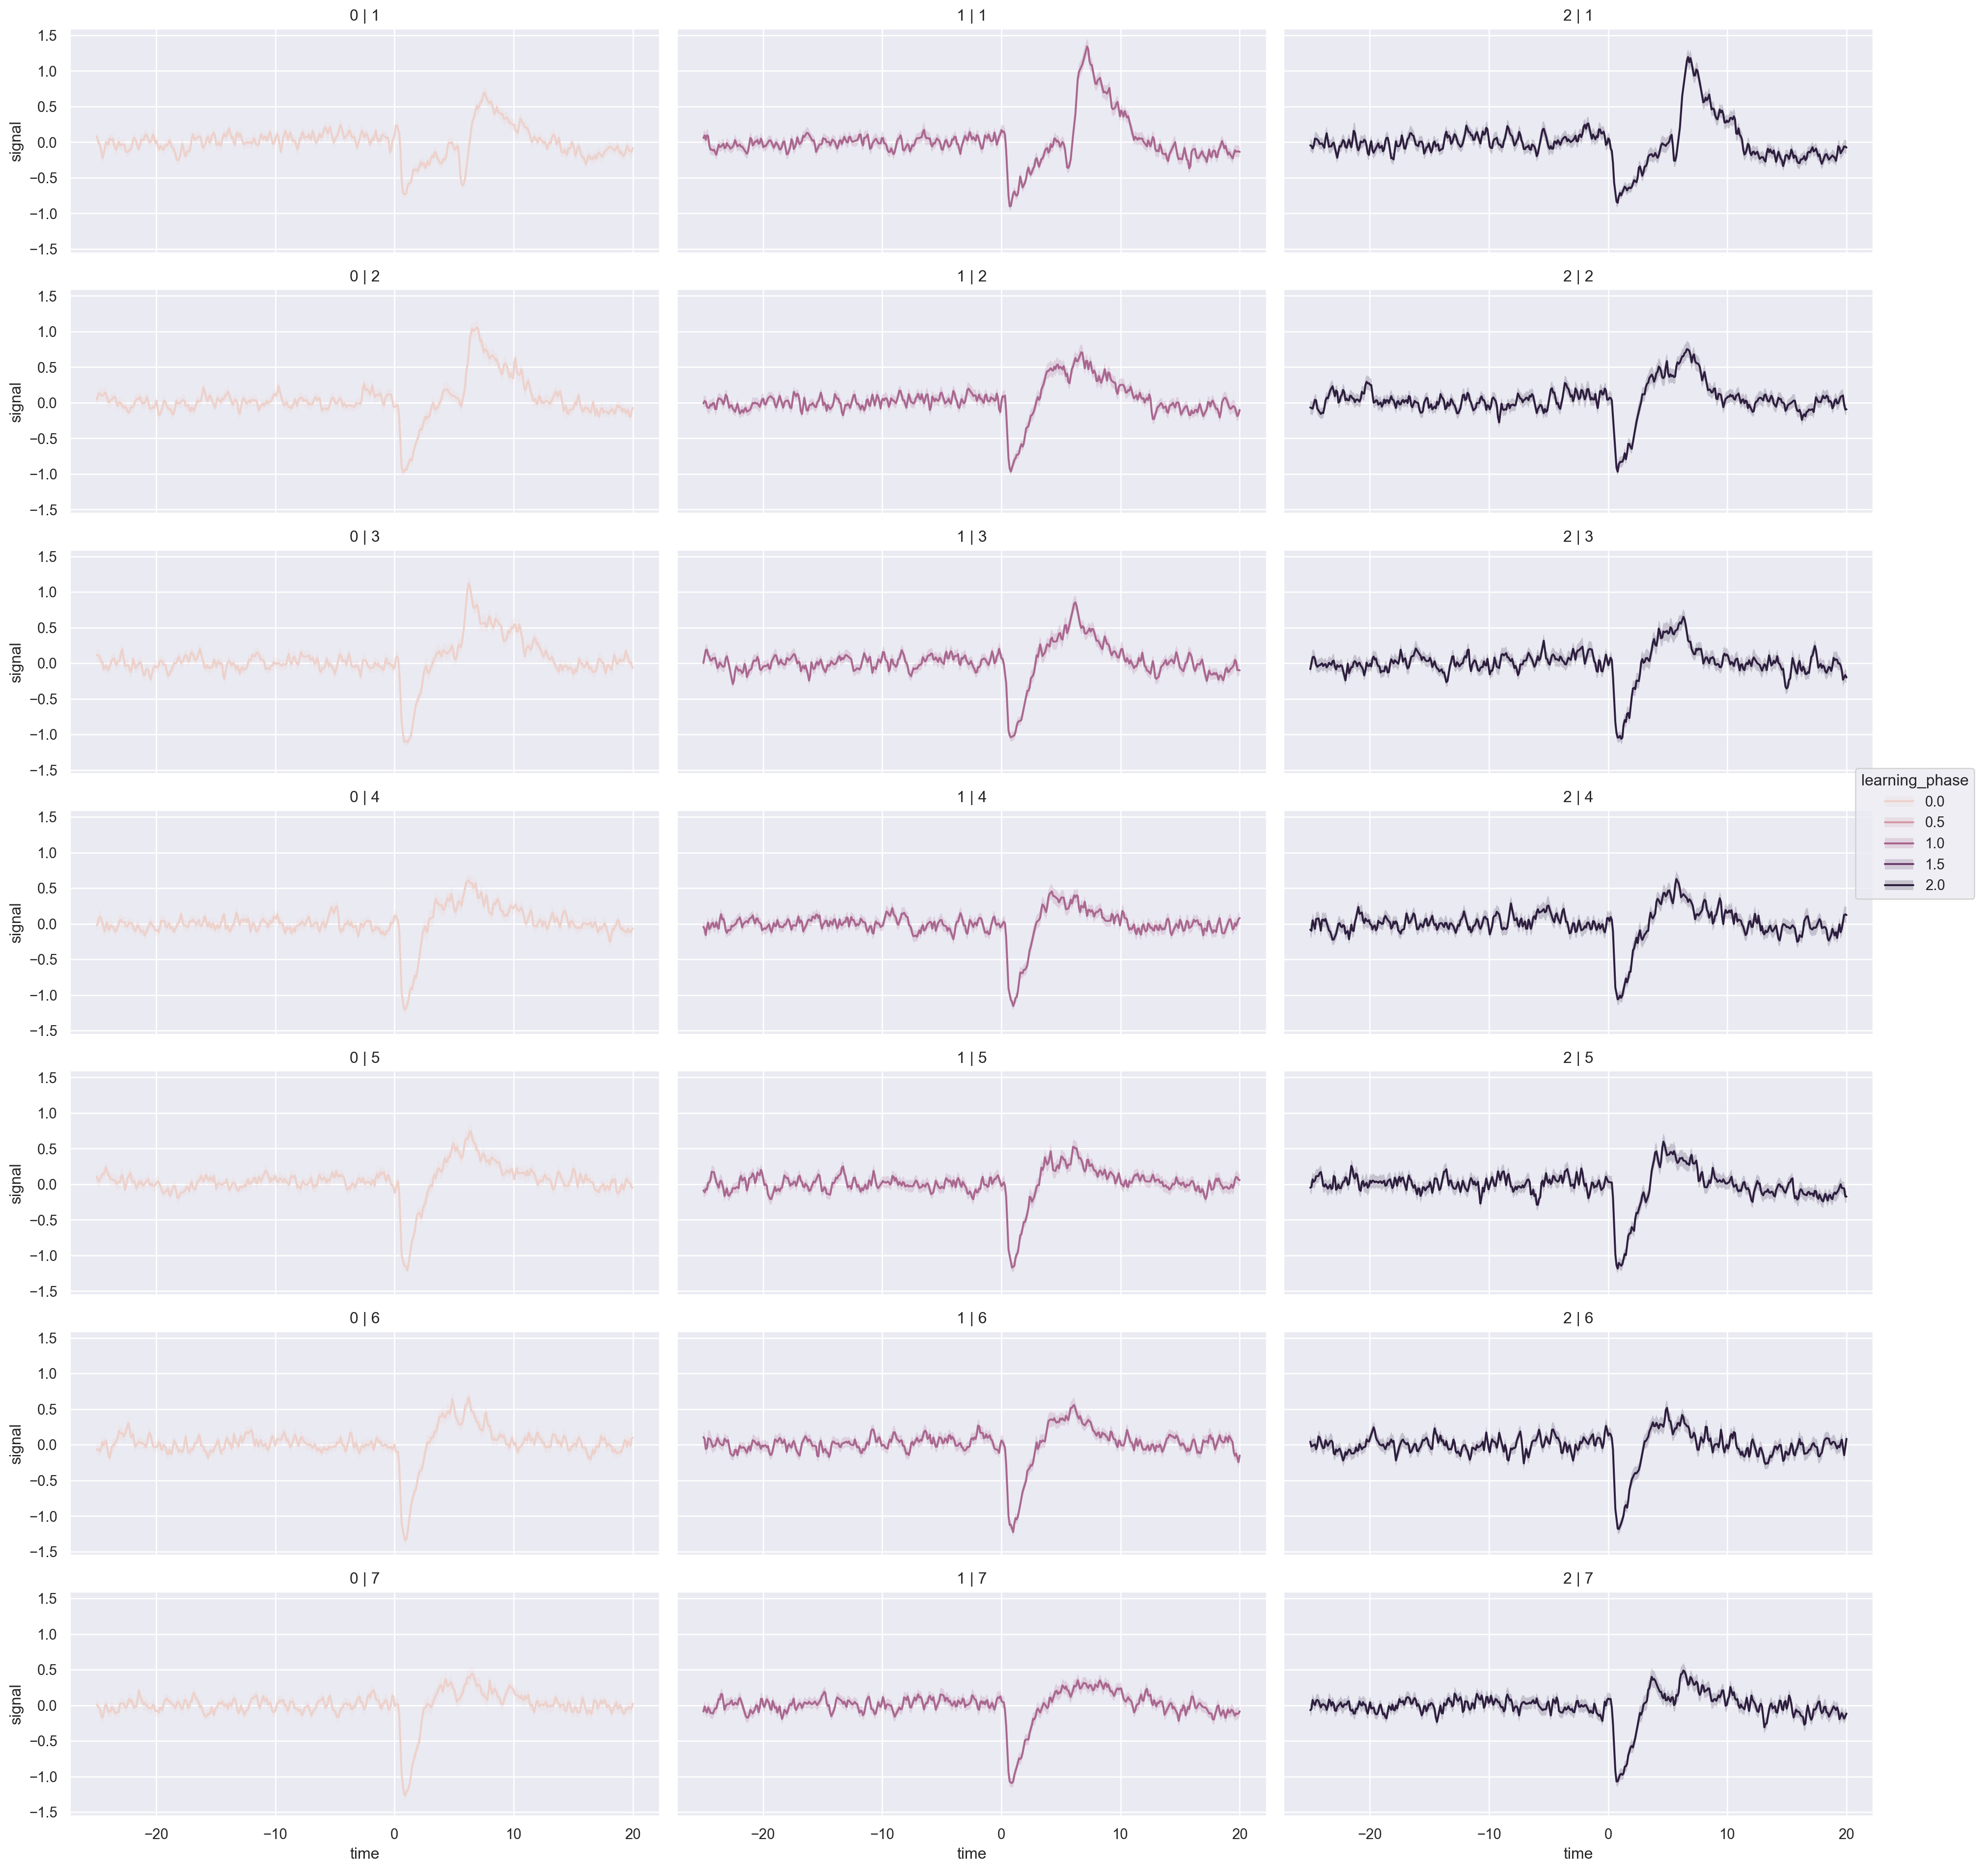

In [220]:
query = data.query("event_cue == 1")
(
    so.Plot(data = query, x = 'time', y = 'signal', color = 'learning_phase')
    .layout(size = (20, 20))
    .add(so.Band(), so.Est(errorbar = 'se'))
    .add(so.Line(), so.Agg())
    .facet("learning_phase", "day")
    .share(y = True, x = True)
    
)

In [374]:
group_data = query.query('time >=0 & time <=10').groupby(by = ['time', 'day', 'learning_phase', 'trial_count'], as_index = False).mean()
peaks = group_data.groupby(by = ['day', 'learning_phase', 'trial_count'], as_index = False).agg(['max', 'min'])['signal'].reset_index()
peaks

,day,learning_phase,trial_count,max,min
0,1,0,0,1.276231,-0.873384
1,1,0,1,0.382031,-0.750714
2,1,0,2,0.441910,-1.367982
3,1,0,3,0.911972,-1.005108
4,1,0,4,0.949659,-0.961349
...,...,...,...,...,...
417,7,2,198,1.097266,-1.041202
418,7,2,199,0.907213,-0.950375
419,7,2,200,0.865036,-1.064868
420,7,2,201,1.337451,-1.512872


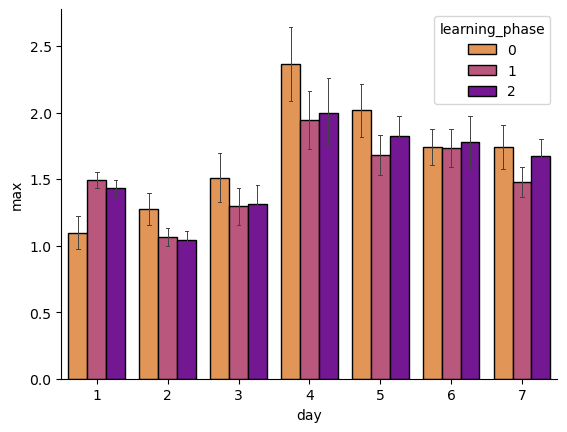

In [375]:
sns.barplot(peaks, x = 'day', y = 'max', hue = 'learning_phase', dodge=True,
              errorbar = 'se', capsize = 0.05, edgecolor = 'black', errwidth=0.7, palette = 'plasma_r')
# plt.set_label('Peak values by learning phase')
sns.despine()

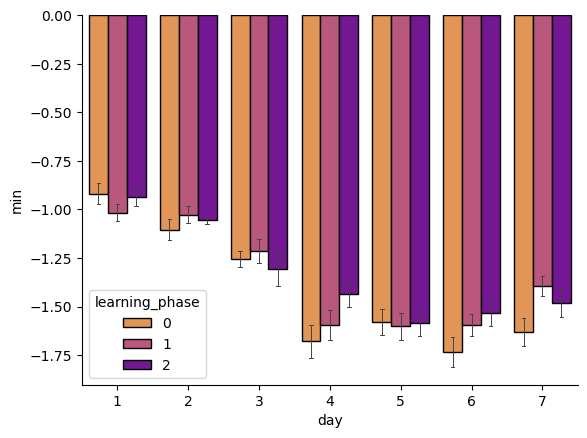

In [378]:
sns.barplot(peaks, x = 'day', y = 'min', hue = 'learning_phase', dodge=True,
              errorbar = 'se', capsize = 0.05, edgecolor = 'black', errwidth=0.7, palette = 'plasma_r')
# plt.set_label('Peak values by learning phase')
sns.despine()

In [131]:
from tensorflow.keras.layers import TimeDistributed    
from tensorflow.keras.layers import Flatten,  Reshape


class TestLSTM(Model):
    """_summary_

    Parameters
    ----------
    Model : _type_
        _description_
    """

    def __init__(self,
                 input_dimensions,
                 lstm_units):
        super(TestLSTM, self).__init__()
        self.input_dimensions = input_dimensions
        self.lstm_units = lstm_units

        # Define layers
        self.lstm_1 = LSTM(self.lstm_units, input_shape=self.input_dimensions,
                           return_sequences=True, name='LSTM_1')
        self.lstm_2 = LSTM(self.lstm_units, name='LSTM_2', return_sequences=True)
        # self.dense = Dense(1, name='Dense_output')

    def call(self, inputs):
        x = self.lstm_1(inputs)
        x = self.lstm_2(x)
        # x = self.dense(x)
        return x
 

In [134]:
X_train = da_proc.train_batches_X[:,::100,:]
y_train = da_proc.train_batches_y[:,::100]
test_model = TestLSTM(input_dimensions=X_train.shape[2:],lstm_units=32)
test_model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mse', 'mape', 'cosine_similarity'])



In [137]:
X_train.shape[1:]

(2440, 14)

In [135]:
test_model.fit(X_train, y_train)


2023-07-31 16:20:37.397359: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-31 16:20:37.398915: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-31 16:20:37.400747: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

ValueError: in user code:

    File "/Users/michaelschaid/opt/anaconda3/envs/enigma/lib/python3.11/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/Users/michaelschaid/opt/anaconda3/envs/enigma/lib/python3.11/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/michaelschaid/opt/anaconda3/envs/enigma/lib/python3.11/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/Users/michaelschaid/opt/anaconda3/envs/enigma/lib/python3.11/site-packages/keras/engine/training.py", line 1051, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/Users/michaelschaid/opt/anaconda3/envs/enigma/lib/python3.11/site-packages/keras/engine/training.py", line 1109, in compute_loss
        return self.compiled_loss(
    File "/Users/michaelschaid/opt/anaconda3/envs/enigma/lib/python3.11/site-packages/keras/engine/compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/Users/michaelschaid/opt/anaconda3/envs/enigma/lib/python3.11/site-packages/keras/losses.py", line 142, in __call__
        losses = call_fn(y_true, y_pred)
    File "/Users/michaelschaid/opt/anaconda3/envs/enigma/lib/python3.11/site-packages/keras/losses.py", line 268, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/Users/michaelschaid/opt/anaconda3/envs/enigma/lib/python3.11/site-packages/keras/losses.py", line 1470, in mean_squared_error
        return backend.mean(tf.math.squared_difference(y_pred, y_true), axis=-1)

    ValueError: Dimensions must be equal, but are 32 and 2440 for '{{node mean_squared_error/SquaredDifference}} = SquaredDifference[T=DT_FLOAT](test_lstm_29/LSTM_2/PartitionedCall:1, IteratorGetNext:1)' with input shapes: [?,2440,32], [?,2440].


In [120]:
prediction = model.predict(X_train)

1/1 [==============================] - 0s 345ms/step


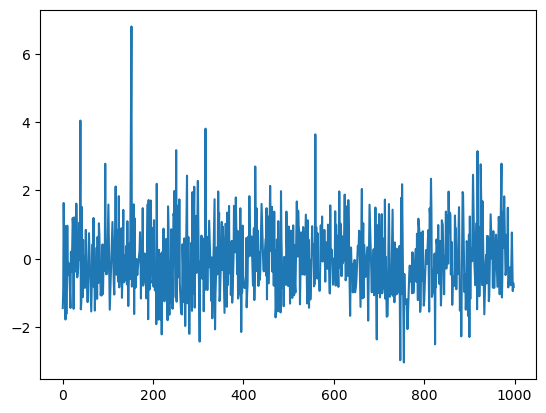

In [122]:
prediction

array([[-18.458645],
       [-18.458807],
       [-18.458467],
       [-18.45954 ],
       [-18.458563],
       [-18.459013],
       [-18.459839],
       [-18.458899],
       [-18.46004 ]], dtype=float32)